In [1]:
import h5py
import pandas as pd
import numpy as np
from typing import Union
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.stats as ss
import seaborn as sns
import cv2 as cv
import os
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def import_blobs(grp: Union[h5py.Group, None], color: str) -> Union[pd.DataFrame, None]:
    if grp is None:
        return None

    return pd.DataFrame({"x": grp[f"{color}/x"][:], "y": grp[f"{color}/y"][:]})


def process_blobs(path_to_h5, overlap_cfx_cutoff):
    dfs = []
    with h5py.File(path_to_h5) as h5:
        for grp in h5:
            scores = h5[f"{grp}/scores"][:]
            blob_paths = [f"{grp}/blobs/{blob}" for blob in h5[f"{grp}/blobs/"]]

            assert len(scores) == len(blob_paths)
            for blob_path, score in zip(blob_paths, scores):
                if score < overlap_cfx_cutoff:
                    continue
                blobs1 = import_blobs(h5[blob_path], "green")
                blobs1["color"] = "green"
                blobs1["cell"] = blob_path

                # Red probes are always A, which is present in 6 copies in C1, so we cannot use it
                # blobs2 = import_blobs(h5[blob_path], "red")
                # blobs2["color"] = "red"
                # blobs2["cell"] = blob_path

                # dfs.append(pd.concat([blobs1, blobs2]))
                dfs.append(blobs1)

    return pd.concat(dfs)


def process_contours(path, overlap_cfx_cutoff):
    data = []
    with h5py.File(path) as h5:
        for grp in h5:
            scores = h5[f"{grp}/scores"][:]
            labels = h5[f"{grp}/contours/label"][:]
            x = h5[f"{grp}/contours/x"][:]
            y = h5[f"{grp}/contours/y"][:]

            imgs = {}
            for (
                i,
                path,
            ) in enumerate(h5[f"{grp}/imgs/"]):
                if not path.startswith("000_") and scores[i - 1] >= overlap_cfx_cutoff:
                    imgs[i - 1] = (path, h5[f"{grp}/imgs/{path}"][:])

            df = pd.DataFrame(
                {"cell": [grp] * len(labels), "label": labels, "x": x, "y": y}
            )
            for (cell, cid), dff in df.groupby(["cell", "label"]):
                if not cid in imgs:
                    continue
                path, img = imgs[cid]

                yshape, xshape = img.shape[0:2]
                xshape += 1
                yshape += 1

                m = np.zeros([yshape, xshape], dtype=np.uint8)

                x = dff["x"].astype(int)
                y = dff["y"].astype(int)

                m[y, x] = 1

                M = cv.moments(m)

                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                data.append([cell, path, cx, cy])

    return pd.DataFrame(
        data, columns=["cell", "centroid_id", "centroid_x", "centroid_y"]
    )

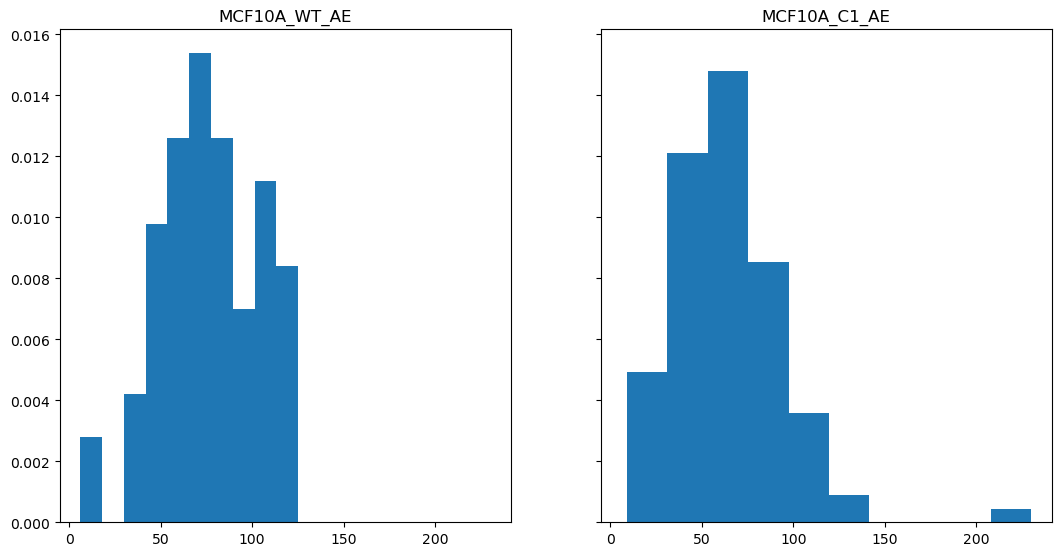

In [3]:
files = [
    # "../data/output/fish/MCF10A_WT_AD_segmented_nuclei_with_blobs.h5",
    # "../data/output/fish/MCF10A_C1_AD_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_WT_AE_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_C1_AE_segmented_nuclei_with_blobs.h5",
]

fig, axs = plt.subplots(
    1, len(files), figsize=(len(files) * 6.4, 6.4), sharex=True, sharey=True
)

dfs = {}

for f, ax in zip(files, axs):
    blobs = process_blobs(f, 0.95)
    centroids = process_contours(f, 0.95)
    dfs_ = []
    for _, row in centroids.iterrows():
        cell, cid = row["cell"], row["centroid_id"]
        cell = f"{cell}/blobs/{cid}"
        x, y = row["centroid_x"], row["centroid_y"]
        df = blobs[blobs["cell"] == cell].copy()
        df["dist"] = np.sqrt(np.power(df["x"] - x, 2) + np.power(df["y"] - y, 2))
        dfs_.append(df)

    df = pd.concat(dfs_)
    title = os.path.basename(f).removesuffix("_segmented_nuclei_with_blobs.h5")
    dfs[title] = df

    ax.hist(df["dist"], density=True)
    ax.set(title=title)

fig.savefig("/tmp/fish_radial_positioning_hist.svg")

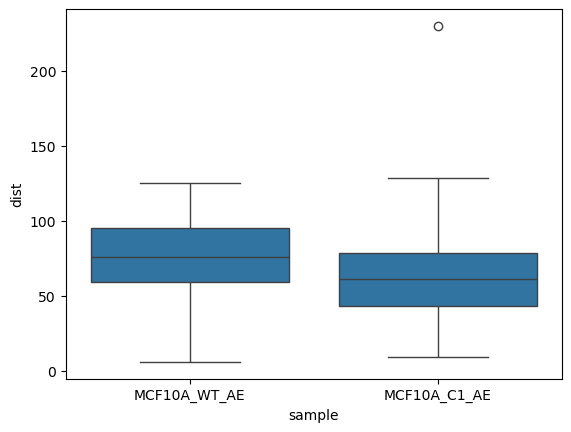

In [4]:
files = [
    # "../data/output/fish/MCF10A_WT_AD_segmented_nuclei_with_blobs.h5",
    # "../data/output/fish/MCF10A_C1_AD_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_WT_AE_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_C1_AE_segmented_nuclei_with_blobs.h5",
]

fig, axs = plt.subplots()

dfs = {}

for f in files:
    blobs = process_blobs(f, 0.95)
    centroids = process_contours(f, 0.95)
    dfs_ = []
    for _, row in centroids.iterrows():
        cell, cid = row["cell"], row["centroid_id"]
        cell = f"{cell}/blobs/{cid}"
        x, y = row["centroid_x"], row["centroid_y"]
        df = blobs[blobs["cell"] == cell].copy()
        df["dist"] = np.sqrt(np.power(df["x"] - x, 2) + np.power(df["y"] - y, 2))
        dfs_.append(df)

    df = pd.concat(dfs_)
    title = os.path.basename(f).removesuffix("_segmented_nuclei_with_blobs.h5")
    df["sample"] = title
    dfs[title] = df

sns.boxplot(pd.concat(dfs.values()), x="sample", y="dist")
ax.set(title=title)

fig.savefig("/tmp/fish_radial_positioning_boxplot.svg")

In [5]:
dff = pd.concat(dfs.values())
wt = dff[dff["sample"] == "MCF10A_WT_AE"]
c1 = dff[dff["sample"] == "MCF10A_C1_AE"]

print(
    dff.groupby(["cell", "sample"])
    .size()
    .groupby("sample")
    .size()
    .to_frame()
    .rename(index={"MCF10A_WT_AE": "WT (nuclei)", "MCF10A_C1_AE": "C1 (nuclei)"})
)
print("WT (obs)", len(wt))
print("C1 (obs)", len(c1))

              0
sample         
C1 (nuclei)  43
WT (nuclei)  28
WT (obs) 60
C1 (obs) 101


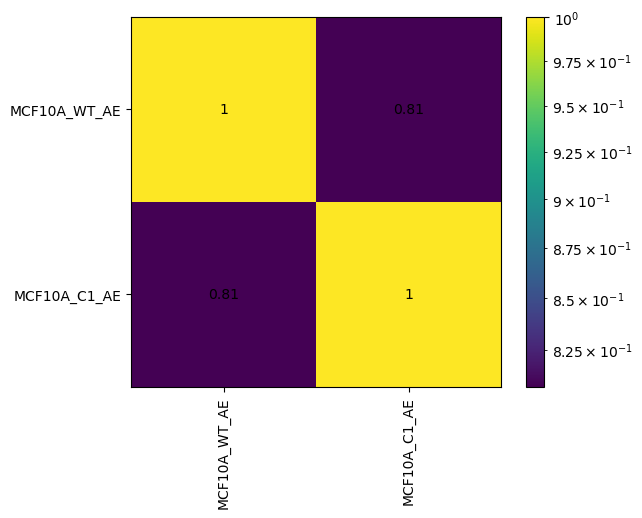

In [6]:
m = np.ones([len(dfs), len(dfs)])
for i, (sample1, df1) in enumerate(dfs.items()):
    for j, (sample2, df2) in enumerate(dfs.items()):
        m[i, j] = ss.levene(df1["dist"], df2["dist"], center="median").pvalue

fig, ax = plt.subplots()

keys = {k: i for i, k in enumerate(dfs.keys())}
img = ax.imshow(m, norm=LogNorm())
for (j, i), label in np.ndenumerate(m):
    ax.text(i, j, f"{label:.2g}", ha="center", va="center")

ax.set_xticks(list(keys.values()), list(keys.keys()), rotation=90)
ax.set_yticks(list(keys.values()), list(keys.keys()))

plt.colorbar(img, ax=ax)

In [7]:
files = [
    # "../data/output/fish/MCF10A_WT_AD_segmented_nuclei_with_blobs.h5",
    # "../data/output/fish/MCF10A_C1_AD_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_WT_AE_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_C1_AE_segmented_nuclei_with_blobs.h5",
]

with PdfPages("/tmp/fish_centroids.pdf") as pdf:
    with h5py.File(files[0]) as h5:
        centroids = process_contours(files[0], 0.95)
        for grp in h5:
            imgs = {}
            scores = h5[f"{grp}/scores"][:]
            for i, path in enumerate(h5[f"{grp}/imgs/"]):
                if not path.startswith("000_"):
                    imgs[i - 1] = (path, h5[f"{grp}/imgs/{path}"][:], scores[i - 1])

            fig, axs = plt.subplots(1, len(imgs), figsize=(6.4 * len(imgs), 6.4))
            if len(imgs) == 1:
                axs = [axs]
            for (path, img, score), ax in zip(imgs.values(), axs):
                ax.imshow(img)

                centroid = centroids[
                    (centroids["cell"] == grp)
                    & (centroids["centroid_id"] == path.split("/")[-1])
                ]

                ax.scatter(
                    centroid["centroid_x"], centroid["centroid_y"], s=20, color="white"
                )
                ax.set(title=str(score))

            fig.suptitle(grp)
            fig.tight_layout()
            pdf.savefig(fig, dpi=300)
            plt.close(fig)